In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

import pathlib
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
BATCH_SIZE = 32
ROOT = "./dataset/fungi/fungi_train_val/images/"

In [3]:
torch.tensor([1,2], device='cuda')

tensor([1, 2], device='cuda:0')

In [4]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.RandomRotation(degrees=(30, 70)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])
# the validation transforms
valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

In [5]:
dataset = datasets.ImageFolder(
    root = f"{ROOT}",
    transform = valid_transform
)
dataset.__len__()

89760

In [6]:
indices = list(range(dataset.__len__()))
split = int(np.floor(0.2 * dataset.__len__()))
np.random.shuffle(indices)
from torch.utils.data.sampler import SubsetRandomSampler
train_indices, val_indices = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, 
                                           batch_size=BATCH_SIZE, 
                                           sampler=train_sampler,
                                            num_workers = 4, 
                                            pin_memory=True
                                           )
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,
                                                sampler=valid_sampler,
                                                num_workers = 4, 
                                                pin_memory=True
                                                )

In [7]:


# training dataset
# train_dataset = datasets.ImageFolder(
#     root= f'{ROOT}/train',
#     transform=train_transform
# )
# # validation dataset
# valid_dataset = datasets.ImageFolder(
#     root= f'{ROOT}/val',
#     transform=valid_transform
# )
# training data loaders
# train_loader = DataLoader(
#     train_dataset, 
#     batch_size=BATCH_SIZE, 
#     shuffle=True,
#     num_workers = 4, 
#     pin_memory=True
# )
# # validation data loaders
# valid_loader = DataLoader(
#     valid_dataset, 
#     batch_size=BATCH_SIZE, 
#     shuffle=False,
#     num_workers = 4, 
#     pin_memory=True
# )

In [8]:
classes = dataset.classes
len(classes)

1394

tensor([ 528, 1076,   93,  852, 1266, 1347, 1282, 1143,  779, 1378,  644,  739,
        1032,  820,  674,  445, 1156, 1183,  464,   22,  695,  119,  356,  358,
        1042, 1205,   52,  808, 1156,  221,  470,  617])


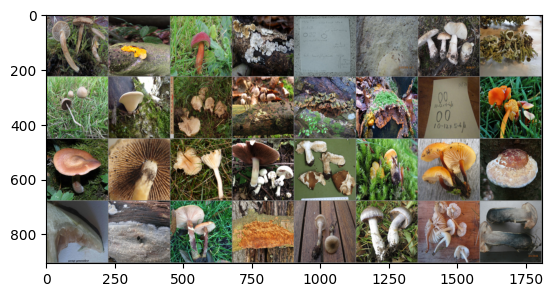

15355_Inocybe_dulcamara
21037_Tremella_mesenterica
11095_Hortiboletus_rubellus
18882_Plicatura_crispa
61261_Coprinopsis_nivea
65994_Amyloporia_xantha
63479_Amanita_rubescens
30413_Hypogymnia_tubulosa
17949_Panaeolus_foenisecii
67489_Cerioporus_varius
16236_Lepista_irina
17258_Mycena_metata
20630_Stereum_hirsutum
18448_Phlebia_radiata
16684_Marasmiellus_ramealis
14822_Hygrocybe_cantharellus
40392_Armillaria_lutea
44084_Lacrymaria_lacrymabunda
14859_Cuphophyllus_pratensis
10116_Agaricus_xanthodermus
16816_Melanoleuca_grammopodia
11325_Cantharellus_pallens
14056_Flammulina_velutipes var. velutipes
14064_Fomitopsis_pinicola
20697_Stropharia_cyanea
47261_Radulomyces_confluens
10527_Armillaria_ostoyae
18385_Fuscoporia_ferrea
40392_Armillaria_lutea
12479_Cortinarius_largus
14867_Cuphophyllus_russocoriaceus
16090_Leccinum_duriusculum


In [9]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(labels)
imshow(torchvision.utils.make_grid(images))
print('\n'.join(f'{classes[labels[j]]:5}' for j in range(BATCH_SIZE)))

In [10]:
def save_model(epochs, model, optimizer, criterion):
    torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, './models/model.pth')
def save_plots(train_acc, valid_acc, train_loss, valid_loss):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # accuracy plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='green', linestyle='-', 
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='-', 
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('outputs/accuracy.png')
    
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='orange', linestyle='-', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-', 
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('outputs/loss.png')

In [11]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.conv4 = nn.Conv2d(128, 256, 5)
        
        # self.fc1 = nn.Linear(256, 50)
        self.fc1 = nn.Linear(256, len(classes))
        
        self.pool = nn.MaxPool2d(2, 2)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        bs, _, _, _ = x.shape
        x = F.adaptive_avg_pool2d(x, 1).reshape(bs, -1)
        x = self.fc1(x)
        return x

In [12]:
def train(model, trainloader, optimizer, criterion, device='cuda'):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # forward pass
        outputs = model(image)
        # print(outputs.shape)
        # calculate the loss
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # calculate the accuracy
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        # backpropagation
        loss.backward()
        # update the optimizer parameters
        optimizer.step()
    
    # loss and accuracy for the complete epoch
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc
# validation
def validate(model, testloader, criterion, device='cuda'):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # forward pass
            outputs = model(image)
            # calculate the loss
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # calculate the accuracy
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
        
    # loss and accuracy for the complete epoch
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

In [13]:
lr = 2e-4
epochs = 10
device = ('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print(f"Computation device: {device}\n")
model = CNNModel().to(device)
print(model)
# total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")
optim = optim.RAdam(model.parameters(), lr=lr)
loss = nn.CrossEntropyLoss()
# loss = nn.BCELoss()

Computation device: cuda

CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=1394, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
1,305,266 total parameters.
1,305,266 training parameters.


In [14]:
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
# start the training
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(model, train_loader, 
                                              optimizer=optim, 
                                              criterion=loss
                                              )
    valid_epoch_loss, valid_epoch_acc = validate(model, validation_loader,  
                                                 criterion=loss,
                                                 )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print('-'*50)
    # time.sleep(5)
    
    save_model(epochs, model, optimizer=optim, criterion=loss)
# save_plots(train_acc, valid_acc, train_loss, valid_loss)
print('TRAINING COMPLETE')

[INFO]: Epoch 1 of 10
Training


100%|██████████| 2244/2244 [34:54<00:00,  1.07it/s] 

Validation



100%|██████████| 561/561 [08:03<00:00,  1.16it/s]


Training loss: 6.925, training acc: 0.446
Validation loss: 6.780, validation acc: 0.207
--------------------------------------------------
[INFO]: Epoch 2 of 10
Training


  4%|▍         | 93/2244 [01:23<32:13,  1.11it/s] 


KeyboardInterrupt: 

In [ ]:
'''[INFO]: Epoch 1 of 10
Training
100%|██████████| 4310/4310 [13:14<00:00,  5.43it/s]
Validation

100%|██████████| 1078/1078 [01:04<00:00, 16.70it/s]
Training loss: 5.522, training acc: 1.332
Validation loss: 5.461, validation acc: 0.371
--------------------------------------------------
[INFO]: Epoch 2 of 10
Training

100%|██████████| 4310/4310 [13:04<00:00,  5.49it/s]
Validation

100%|██████████| 1078/1078 [01:05<00:00, 16.54it/s]
Training loss: 5.404, training acc: 1.926
Validation loss: 5.416, validation acc: 0.529
--------------------------------------------------
[INFO]: Epoch 3 of 10
Training

100%|██████████| 4310/4310 [13:11<00:00,  5.44it/s]
Validation

100%|██████████| 1078/1078 [01:11<00:00, 15.11it/s]
Training loss: 5.354, training acc: 1.958
Validation loss: 5.361, validation acc: 0.492
--------------------------------------------------
[INFO]: Epoch 4 of 10
Training
'''

In [ ]:
save_model(epochs, model, optimizer, criterion)

In [ ]:
# model = CNNMOdel().to(device)
# checkpoint = torch.load('outputs/model.pth', map_location=device)
# model.load_state_dict(checkpoint['model_state_dict'])
# model.eval()

In [ ]:
import cv2
file_name_test = "./dataset/fungi/val/10000_Abortiporus_biennis/FVL2009PIC65515416.JPG"
image = cv2.imread(file_name_test)

# get the ground truth class
# gt_class = "10000_Abortiporus_biennis"
gt_class = file_name_test.split('/')[-2]
# model.eval()

# convert to RGB format
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
orig_image = image.copy()
# plt.imshow(image);
# plt.show()
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
]) 
image = transform(image)
# add batch dimension
image = torch.unsqueeze(image, 0)
with torch.no_grad():
    outputs = model(image.to(device))
output_label = torch.topk(outputs, 1)
pred_class = classes[int(output_label.indices)]
prob_class = np.round(float(output_label.values), 3)
cv2.putText(orig_image, 
    f"GT: {gt_class}",
    (10, 25),
    cv2.FONT_HERSHEY_SIMPLEX, 
    0.9, (0, 255, 0), 2, cv2.LINE_AA
)
cv2.putText(orig_image, 
    f"Pred: {pred_class}",
    (10, 55),
    cv2.FONT_HERSHEY_SIMPLEX, 
    0.9, (0, 0, 255), 2, cv2.LINE_AA
)
cv2.putText(orig_image, 
    f"Pred: {prob_class}",
    (10, 85),
    cv2.FONT_HERSHEY_SIMPLEX, 
    0.9, (255, 255, 255), 2, cv2.LINE_AA
)
print(f"GT: {gt_class}, pred: {pred_class}, prob: {prob_class}")
# cv2.imshow('Result', orig_image)
# cv2.waitKey(0)
# cv2.imwrite(f"outputs/{gt_class}{args['input'].split('/')[-1].split('.')[0]}.png",
    # orig_image)
plt.imshow(orig_image);